# 15-9. 프로젝트 : 다양한 OCR모델 비교하기

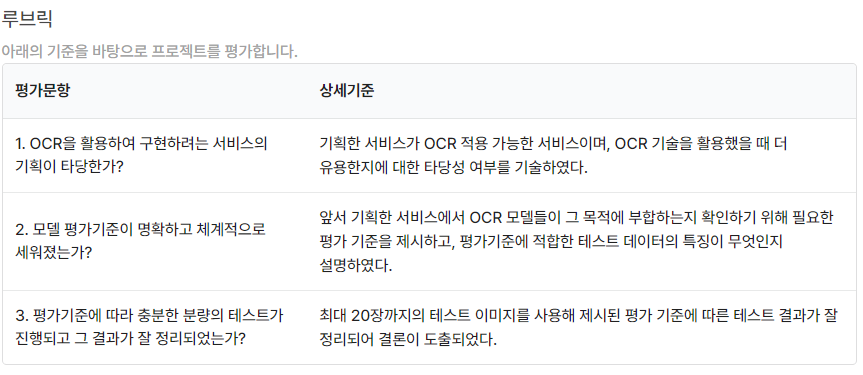

우리는 지금까지 Google OCR API, keras-ocr, Tesseract 이상 3가지의 OCR 기능을 간단히 활용하여 보았습니다.

지금까지 살펴본 바로는 무료로 사용할 수 있는 기능들이지만 모두 준수한 성능을 갖추고 있었습니다. OCR 분야가 이미 실용적인 수준에까지 기술이 발전했기 때문에 이런 것들만 잘 활용해도 실전에 활용할 수 있는 좋은 서비스를 만들어 낼 수 있을 것도 같습니다. 그런데 과연 어떤 것을 사용하는 것이 좋을까요?

OCR 기술들이 실용적인 수준까지 꽤 발전했지만 그럼에도 불구하고 아직 완전한 수준은 아닙니다. 용도에 맞게 적절한 것을 선택하는 것도 중요한 일입니다. 그래서 오늘 다뤄본 위 3가지를 검증해 보는 프로젝트를 진행하겠습니다. 여러분은 OCR 기능을 활용한 서비스를 빠르게 개발해야 하는 임무를 맡은 엔지니어가 되어, 어떤 모듈을 도입하면 좋을지 기술검증을 하는 역할을 맡게 되었다고 가정합니다.

프로젝트를 시작하기 전에 주요 라이브러리 버전을 살펴보죠.

In [1]:
import keras_ocr
import pytesseract

print(keras_ocr.__version__)
print(pytesseract.__version__)
# pytesseract는 tesseract-ocr에 종속적입니다. 아래 명령어를 통해 설치해야 할 수도 있습니다.
# !sudo apt install tesseract-ocr

0.8.8
0.3.8


### Step1. 검증용 데이터셋 준비
----
OCR 관련해서 오늘 다루어본 주제는 텍스트의 모양과 크기, 배치, 노이즈 등 OCR의 성능에 영향을 미치는 요인들에 관한 것이었습니다. 여러분들은 위 3가지 기능들이 이미지에 나타난 특징에 따라 얼마나 정확하게 문자를 detect하고 recognize하는지를 검증하기 위한 이미지 데이터를 모아야 합니다. 이미지가 많을수록 좋겠지만 검증해야 할 항목별로 고루 갖춰지는 것도 중요합니다.

가능하다면 함께 학습하는 동료들과 힘을 합쳐보는 것을 추천합니다. 그렇다고 너무 많은 이미지 데이터로 검증하는 것은 이후 결과를 정리하는 것이 힘들 수 있으니 테스트용 이미지는 아무리 많아도 20장을 넘기지 않는 것으로 합시다.

### 기획 소개
#### 1. 기획의도
- 여행지 식당에 갔을 때 종업원이 내민 메뉴판을 읽을 수 없을때 만큼 당황스러운 순간은 많지 않을것이다. 
- 여행지에 가서 편하게 메뉴를 시킬 수 있도록 메뉴판을 번역해주는 앱을 만드는 것이 목표


#### 2. 구현 목표
- 미니 프로젝트이니 만큼 깊게 들어가기 보다는 ocr모델들이 메뉴판의 문자를 제대로 인식하는지 검증해본다. 
- 많은 언어보다는 일단 영어 인식이 되는지 확인한다. 


#### 3. 데이터 확인
- 인터넷에서 구한 메뉴판 이미지들의 링크는 아래와 같으며, abudhabi에 존재하는 식당의 메뉴판들이다. 
    - https://d4t7t8y8xqo0t.cloudfront.net/resized/1080X/restaurant%2F669161%2Fmenu%2Fmenu01570188654337.jpg
    - https://d4t7t8y8xqo0t.cloudfront.net/resized/1080X/restaurant%2F673954%2Fmenu%2Fmenu01629270994079.jpg
    - https://d4t7t8y8xqo0t.cloudfront.net/resized/1080X/restaurant%2F671391%2Fmenu%2Fmenu11596531860756.jpg
    - https://d4t7t8y8xqo0t.cloudfront.net/resized/1080X/restaurant%2F674040%2Fmenu%2Fmenu21630926028658.jpg
    - https://d4t7t8y8xqo0t.cloudfront.net/resized/1080X/restaurant%2F669161%2Fmenu%2Fmenu11570188668960.jpg
    - https://images.happycow.net/venues/1024/17/84/hcmp17847_717239.jpeg
    - https://media-cdn.tripadvisor.com/media/photo-m/1280/1c/90/33/58/drinks-menu.jpg
    - https://d4t7t8y8xqo0t.cloudfront.net/resized/1080X/restaurant%2F648252%2Fmenu%2Fmenu31504955183428.jpg
    - https://takeawaymenusabudhabi.files.wordpress.com/2013/04/lf.jpg
    - https://image.isu.pub/200301094143-1e6949be31a0b0734902e8ce66b9c2bd/jpg/page_73.jpg

In [2]:
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt

In [3]:
images=glob.glob("./menus/*.jpg")

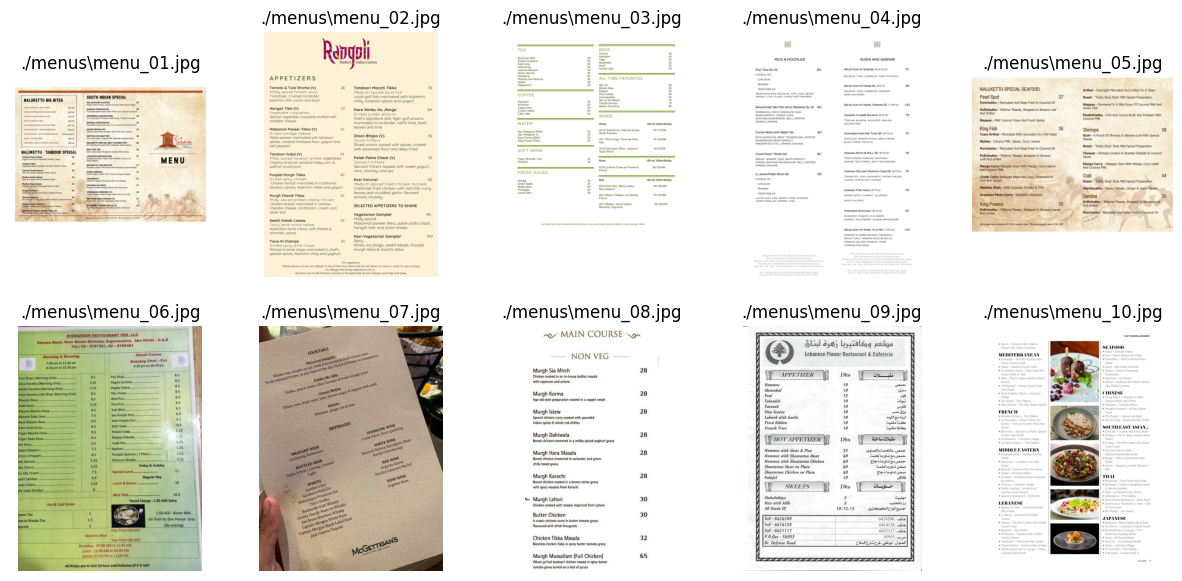

In [4]:
plt.figure(figsize=(15, 7))

for i in range(1, 11):
    plt.subplot(2, 5, i)
    img = Image.open(images[i - 1])
    plt.imshow(img)
    plt.title(img.filename)
    plt.axis('off')
plt.show()

### Step2. keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항)
----
위 두 가지 모듈을 활용하는 방법에 대해서는 코드 레벨로 이미 경험해 보셨을 것입니다. 이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 봅시다. 가능하다면 Google OCR API를 포함해 세 가지 모듈을 다 써보세요.

#### 1) google API

In [5]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    
#     print('Texts:')

#     for text in texts:
#        print('\n"{}"'.format(text.description))

#     vertices = (['({},{})'.format(vertex.x, vertex.y)
#                  for vertex in text.bounding_poly.vertices])

#     print('bounds: {}'.format(','.join(vertices)))
    ocr_text = []
    
    for text in texts:
        ocr_text.append(text.description)

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
    return ocr_text

In [6]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
# !ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  './json/my_google_api_key.json'

menu_ocr = []
images=glob.glob("./menus/*.jpg")

for i in range(1, 11):
    text_l = detect_text(images[i - 1])
    menu_ocr.append(text_l)
    

print(menu_ocr[0])

["NALUKETTU BIG BITES\nKERALA PARATTA, BEEF CURRY\nAPPAM, KUTTANADAN THARAVU ROAST\nCHAPATTI, NADAN KOZHI CURRY\nPUTTU, KADALA CURRY\nNEYCHORU, MAPPILA CHICKEN CURRY\nKOTHU PARATTA- BEEFICHICKENLEGG\nKAPPA BIRYANI - BEEFICHICKEN PRAWNS\nKAPPA - MATHICURRY\nCOIN DOSA-BEEF | CHICKEN | FISH CURRY\nChicken Tikka\nTraditional Spiced Roasted, Boneless Chicken Cubes\nChicken Seekh Kabab\nHerb And Spiced Minced Chicken Kabab\nMutton Seekh Kabab\nHerb And Spiced Minced Mutton Kabab\nMutton Malai Kabab\nYoghurt And Spice Marinated Mutton Cubes\nAED 36\nNALUKETTU - TANDOOR SPECIAL\nChicken Malai Kabab\nYoghurt And Spice Marinated Chicken Cubes.\nJhinga Tandoori\nTraditional Spiced, Full Flavour Roasted Prawns\nAED 36\nAED 36\nAED 38 138157\nAED 35\nAED 36\nPaneer Onion Tikka (V)\nCottage Cheese, Onion And Capsicum Skewers.\nAED 30\nAED 36\nAED 36\n30\nKali Mirch Pudhina Paneer Tikka (V)\nMint Coated Paneer, Black Pepper, Onion And Capsicum\n30\n30\n34\n34\nJhinga Kalimirch\n40\nBlack Pepper Coate

In [13]:
print(menu_ocr[8])

['Hommos\nMoutabal\nFoul\nTabouleh\nFatoush\nAPPETIZER\nVine leaves\nLabneh with Garlic\nFried Kibben\nFrench Fries\nمطعم وكافتيريا زهرة لبنان\nLebanese Flower Restaurant & Cafeteria\n- HOT APPETIZER\nHommos with Meat & Pine\nHommos with Shawarma Meat\nHommos with Shawarma Chicken\nShawarma Meat on Plate\nShawarma Chicken on Plate\nFalafel\nMuhalabiya\nRice with Milk\nAll kinds of\nSWEETS\nTell : 6424208\n| Tell : 6414128\nTell : 6421117\n| P.0.Box : 54955\nBr. Defense Road\nDhs\n10\n10\n15\n10\n10\n10\n10\n10\n10\nDhs\n35\n40\n40\n40\n40\n10\nDhs\n5\n5\n10-12-15\nمقبـلات\nTITI\nمقبلات ساخنة\nD\nحـــــويــــات\nحمص\nمتبل\nفول\nتبولة\nفتوس\nورق عنب\nلبنه مع الثوم\nكبة مقلية\nبطاطا مقلية\nحمص ـ باللحمة والصنوبر\nحمص مع شاورما لحمة\nحمص مع شاورما دجاج\nصحن شاورما لحمة\nصحن شاورما دجاج\nفلافل\nمهلبية\nرز بالحليب\nجميع انواع الكوكتيل\nهاتف : 6424208\nهاتف : 6414128\nهاتف : 6421117\nص.ب : 45955\nالعنوان : ابوظبي - فرع شارع الدفاع', 'Hommos', 'Moutabal', 'Foul', 'Tabouleh', 'Fatoush', 'APPETI

#### 2) keras-ocr

In [7]:
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for C:\Users\aeoli\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\aeoli\.keras-ocr\crnn_kurapan.h5


In [8]:
image_urls = [
  'https://d4t7t8y8xqo0t.cloudfront.net/resized/1080X/restaurant%2F669161%2Fmenu%2Fmenu01570188654337.jpg',
  'https://d4t7t8y8xqo0t.cloudfront.net/resized/1080X/restaurant%2F673954%2Fmenu%2Fmenu01629270994079.jpg',
  'https://media-cdn.tripadvisor.com/media/photo-m/1280/1c/90/33/58/drinks-menu.jpg',
  'https://takeawaymenusabudhabi.files.wordpress.com/2013/04/lf.jpg'
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

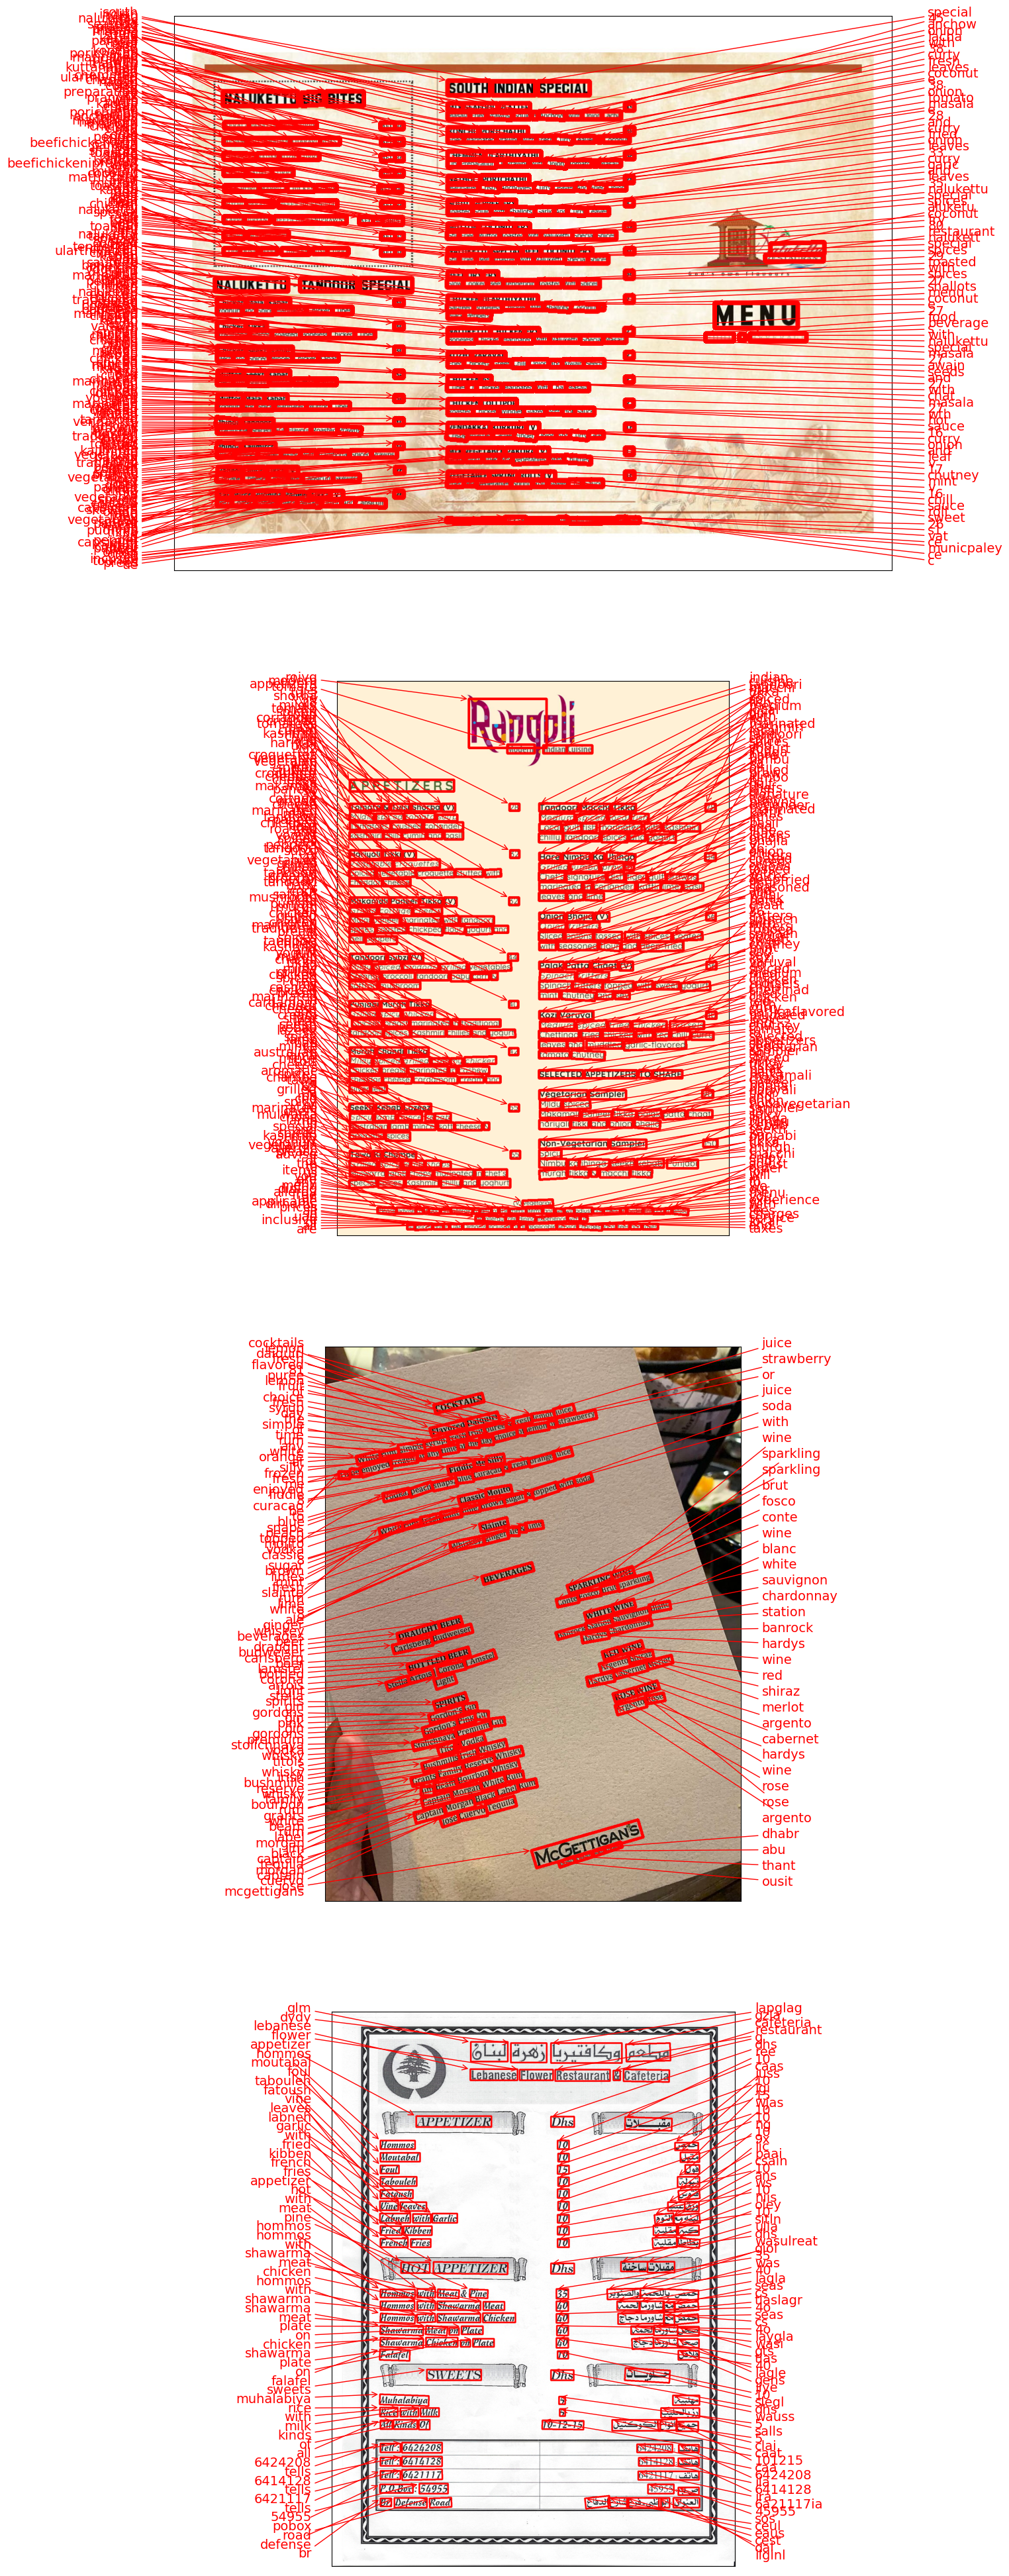

In [12]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(40, 50))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

#### 3) tesseract

In [30]:
import pytesseract
import numpy as np
from pytesseract import Output

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [31]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [33]:
images_dir=glob.glob("./menus/*.jpg")

for i in range(2):
    work_dir = './menus/exm' + ('/0'+str(i))
    img_file_path = images_dir[i]
    cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
    recognize_images(cropped_image_path_list)

./menus/exm/00\0000.png
./menus/exm/00\0001.png
./menus/exm/00\0002.png
./menus/exm/00\0003.png
./menus/exm/00\0004.png
./menus/exm/00\0005.png
./menus/exm/00\0006.png
./menus/exm/00\0007.png
./menus/exm/00\0008.png
./menus/exm/00\0009.png
./menus/exm/00\0010.png
./menus/exm/00\0011.png
./menus/exm/00\0012.png
./menus/exm/00\0013.png
./menus/exm/00\0014.png
./menus/exm/00\0015.png
./menus/exm/00\0016.png
./menus/exm/00\0017.png
./menus/exm/00\0018.png
./menus/exm/00\0019.png
./menus/exm/00\0020.png
./menus/exm/00\0021.png
./menus/exm/00\0022.png
./menus/exm/00\0023.png
./menus/exm/00\0024.png
./menus/exm/00\0025.png
./menus/exm/00\0026.png
./menus/exm/00\0027.png
./menus/exm/00\0028.png
./menus/exm/00\0029.png
./menus/exm/00\0030.png
./menus/exm/00\0031.png
./menus/exm/00\0032.png
./menus/exm/00\0033.png
./menus/exm/00\0034.png
./menus/exm/00\0035.png
./menus/exm/00\0036.png
./menus/exm/00\0037.png
./menus/exm/00\0038.png
./menus/exm/00\0039.png
./menus/exm/00\0040.png
./menus/exm/00\0

Anchovies,

Lurry

—

Ang

erp)

Union

AUT Pius

PARAL LAN

HDEEPILMILAB NI Elety

Ari)

4h

SOUILD

Pr bh he

rey

334

loastea

Squid

With

SHaliots,

Laric

bine

Lurry

| PAYS

Tituva'

HIRYANI - BEE PICHICKEN| PRAWNS

ACU

30

(38/57

F


ee lll |

MUTTON

LOCUONUT

glad

38

Fil!

MATIC Tiny

ARD 35

Shir

aa ne

Miusttory

1oasteq

With

Naligkettu

Special

Spices

ati,

USA ~ Bee

i

Lr hniLh rN


PiStt

Ltinthy

Ab iD

4

MALLIMET TU

SMrciAl

a i

COCONUT

ry

30

aliuhellit

=

Sir

“ed

ee

ast

uth

Na Ketry

Special

Ses

RES TALIRANT

slaaa


glad

29

> oege’ts Own ri iliaueowuwr s

re

NALUKETTU

on

TANDOOR

SPECIAL

Siow

Looked

ee!

Tenderloin

Toasted

With

Spices

7

tl

CHICKEN

ULAR THIYATHU

2/

ay

Se

“ide:

vec

Chicken

Cubes

cit

awe

—"

Licker

With

Shallots.

Coconut &

,

M

-

N

UJ

Chicken

Tikka

eit

ities

=

”

if

WALUMET IU

LHICLAEN

rey

Li

Traditional Spiced

Roasted,

Boneless Ch

Ker

Cubes

Boneless.

Chicken

Mannated

With

Nal

Reb

i

Dl | DI

Cuisine

APPETIZERS

Tomato

&

Tulsi

Shorba

(V)

20

MiTOIY

Spicea

rOmMarO

SOU £—

tomatoes.

crusned

coriander.

KasSNmMiri

Chili.

CUMIN

else

Dasi|

Hariyali

Tikki

(V)

57

Vegetable

croquettes

Spiced

vegetable

croquette

stuffed

with

cheddar

cheese

Makamali

Paneer

TIKKO

(V)

4?

Grilled

cottage

~“neese

Malai

VaNee;r

marinated

witn

tanaoor!

Spices,

roasted

chickpea

flour.

yogurt

anda

De}

YVEVPPEIs

Tandoor!

SubdzZi

(V)

44

Mildy

Sspicea

ranadoor!

grillea

vegetables

Creamy

Droccoli,

tandoori

baby

@Selag

AY

sattron

mushroom

Punjabi

Murgnh

Tikka

4)

(srilled

SPICY

cnicken

( nicken

oreast

marinated

in

traditional

tandoori

Spices,

Kasnmirt

cnilies

‘elele

Yogurt

Murgh

Chandi

Tikka

4°)

MIIOY

Spicea

grilled

creamy

chicken

Chicken

HbDreast

marinated

le

cashew.

chedaadar

cheese,

caraqamom.

Crea;

anda

silver

eat

Seekh

Kebab

|lazeez

55

Spicy

lamb

fruisfice

kebab

Australian

lambo


### Step3. 테스트 결과 정리
----
모듈들마다 출력 형태가 다릅니다. 분석을 위해 결과를 일목요연하게 정리해 보는 것이 도움이 될 것입니다. 시각화 방법이 함께 활용된다면 더욱 좋겠군요.

### Step4. 결과 분석과 결론 제시
----
우선 여러분들이 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다. 여러분들이 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가 기준을 제시합니다. 그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.

## 결론
### 1) 필요 요건
메뉴판 번역기 어플을 만들기 위해서는 필수적으로 갖춰야 하는 아래의 두가지 요건이 필요하다. 
1) 특별한 설정없이 ocr과정에서 메뉴판의 언어를 확인하고, 그 언어에 맞게 ocr이 진행되어야 한다.
2) ocr 후 반환하는 데이터에 인식한 글자의 bounding box의 위치를 반환해줘야 그 위치를 기초로 번역을 진행 하여 시각화 할 것이다. 

### 2) 각 모델 검토
#### ① google OCR API
- 위 두 요건을 모두 충족하는 유일한 모델이다. 
- 아랍어도 정확하게 ocr을 하고 있는 것을 보여준다. 
- 현재 코드 상으로 인식한 text만 반환하고 있지만 ocr과정에서 bounding box도 충분히 뽑아 낼 수 있음을 알 수 있다. 
- 속도도 3가지 모델중 가장 빠르다

#### ② keras-ocr
- keras-ocr의 경우 시각화에 강점을 보인다.
- bounding box의 위치를 잘 반환하고 있으나, 언어를 제대로 인식하지는 못하고 모두 영어로 인식해서 출력하고 있다. 
- 속도도 가장 느린편에 속한다. 

#### ③ Tesseract OCR
- bounding box의 크기와 위치를 출력하는 듯 하고, 언어별로 선택해서 ocr해서 제한적으로 다양한 언어를 ocr 할수 있다고 생각된다.
- ocr 할때마다 언어의 종류를 정해줘야 하는 점, 한번에 두가지 이상의 언어를 제대로 인식하고 있지 못하다는 점
- 속도도 상당히 느린편이며, bounding box의 영역이 정확하지 않은 점 등 단점이 많아 보인다. 

### 3) 모델 선택
- google OCR API가 메뉴판 번역 어플로서 가장 적합한 모델이라 생각된다. 